In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

In [2]:
# Configuration
sns.set()
plt.rcParams.update({
    'figure.figsize': (4*1.8, 3*1.8),
    'figure.dpi': 300,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.usetex': True,
    'text.latex.preamble': [
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{siunitx}',
        r'\usepackage{physics}',
        r'\usepackage{amsmath}'
    ]
})
%config InlineBackend.figure_format = 'retina'

In [3]:
# MIREX measurement
reference = pd.read_csv('nephelometer_002.dat', '\t|;', index_col=0, skiprows=19, engine='python')
reference = reference.apply(lambda c: c.str.replace(',', '.')).astype(float).rename(columns=lambda c: c.strip())
reference.index = pd.to_datetime(reference.index) - pd.to_datetime(reference.index[0])
reference = reference.resample('500ms').interpolate('time')
reference.index.name = None
reference['sec'] = reference.index.values.astype(float) * 1e-9
reference

Sample         MIREX  Stroemung    Temp.     sec
00:00:00            0.0  5.573000e-08    0.12630  0.04189     0.0
00:00:00.500000     0.5  1.554528e-03    0.12430  0.04189     0.5
00:00:01            1.0  3.109000e-03    0.12230  0.04189     1.0
00:00:01.500000     1.5  1.554528e-03    0.12430  0.04189     1.5
00:00:02            2.0  5.573000e-08    0.12630  0.04189     2.0
...                 ...           ...        ...      ...     ...
00:19:09         1149.0  1.561000e+00    0.12230  0.04189  1149.0
00:19:09.500000  1149.5  1.558000e+00    0.12430  0.04189  1149.5
00:19:10         1150.0  1.555000e+00    0.12630  0.04189  1150.0
00:19:10.500000  1150.5  1.558000e+00    0.12325  0.04189  1150.5
00:19:11         1151.0  1.561000e+00    0.12020  0.04189  1151.0

[2303 rows x 5 columns]

In [4]:
# Nephelometer measurement
nephelometer = pd.read_csv('messung.txt', '\ |,', index_col=0, engine='python').iloc[:, 1:]        # Import data
nephelometer.index = pd.to_datetime(nephelometer.index) - pd.to_datetime(nephelometer.index[0])    # Normalize timestamps
nephelometer = nephelometer.resample('500ms').ffill()                                              # Upsample for synchronous data
nephelometer.index.name = None
nephelometer['sec'] = nephelometer.index.values.astype(float) * 1e-9

# The relation between integration times is not precisely linear (due to arduino program)
def scale(data_from, data_to):
    return LinearRegression(fit_intercept=False).fit(data_from[:, np.newaxis], data_to[:, np.newaxis]).coef_[0][0]

# Remove background measurement from measurement with LED turned on and normalize values.
for i in ['200', '150', '100', '50', '20', '10']:
    nephelometer[f'i{i}'] = (nephelometer[f'on_{i}ms'] 
                             - (scale(nephelometer.on_100ms, nephelometer[f'on_{i}ms'])
                                * nephelometer.off_100ms.mean()))# / 1024

# Make both the MIREX and nephelometer measurements the same length
reference = reference[:len(nephelometer)]
assert len(reference) == len(nephelometer)    

nephelometer

off_100ms  on_200ms  on_150ms  on_100ms  on_50ms  on_20ms  \
00:00:00                11       599       454       307      159       67   
00:00:00.500000         11       599       454       307      159       67   
00:00:01                11       599       453       305      155       67   
00:00:01.500000          7       599       452       305      157       67   
00:00:02                11       599       453       305      155       67   
...                    ...       ...       ...       ...      ...      ...   
00:19:06                 9       641       484       326      168       72   
00:19:06.500000          9       640       484       327      167       71   
00:19:07                 7       641       485       327      166       70   
00:19:07.500000          7       640       485       328      167       70   
00:19:08                 7       640       485       328      167       70   

                 on_10ms     sec        i200        i150        i100  \
00:00:00              41     0.0  583.171655  442.026825  298.932521   
00:00:00.500000       41     0.5  583.171655  442.026825  298.932521   
00:00:01              35     1.0  583.171655  441.026825  296.932521   
00:00:01.500000       35     1.5  583.171655  440.026825  296.932521   
00:00:02              36     2.0  583.171655  441.026825  296.932521   
...                  ...     ...         ...         ...         ...   
00:19:06              38  1146.0  625.171655  472.026825  317.932521   
00:19:06.500000       39  1146.5  624.171655  472.026825  318.932521   
00:19:07              39  1147.0  625.171655  473.026825  318.932521   
00:19:07.500000       39  1147.5  624.171655  473.026825  319.932521   
00:19:08              39  1148.0  624.171655  473.026825  319.932521   

                        i50        i20        i10  
00:00:00         154.872444  65.254798  40.051625  
00:00:00.500000  154.872444  65.254798  40.051625  
00:00:01         150.872444  65.254798  34.051625  
00:00:01.500000  152.872444  65.254798  34.051625  
00:00:02         150.872444  65.254798  35.051625  
...                     ...        ...        ...  
00:19:06         163.872444  70.254798  37.051625  
00:19:06.500000  162.872444  69.254798  38.051625  
00:19:07         161.872444  68.254798  38.051625  
00:19:07.500000  162.872444  68.254798  38.051625  
00:19:08         162.872444  68.254798  38.051625  

[2297 rows x 14 columns]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


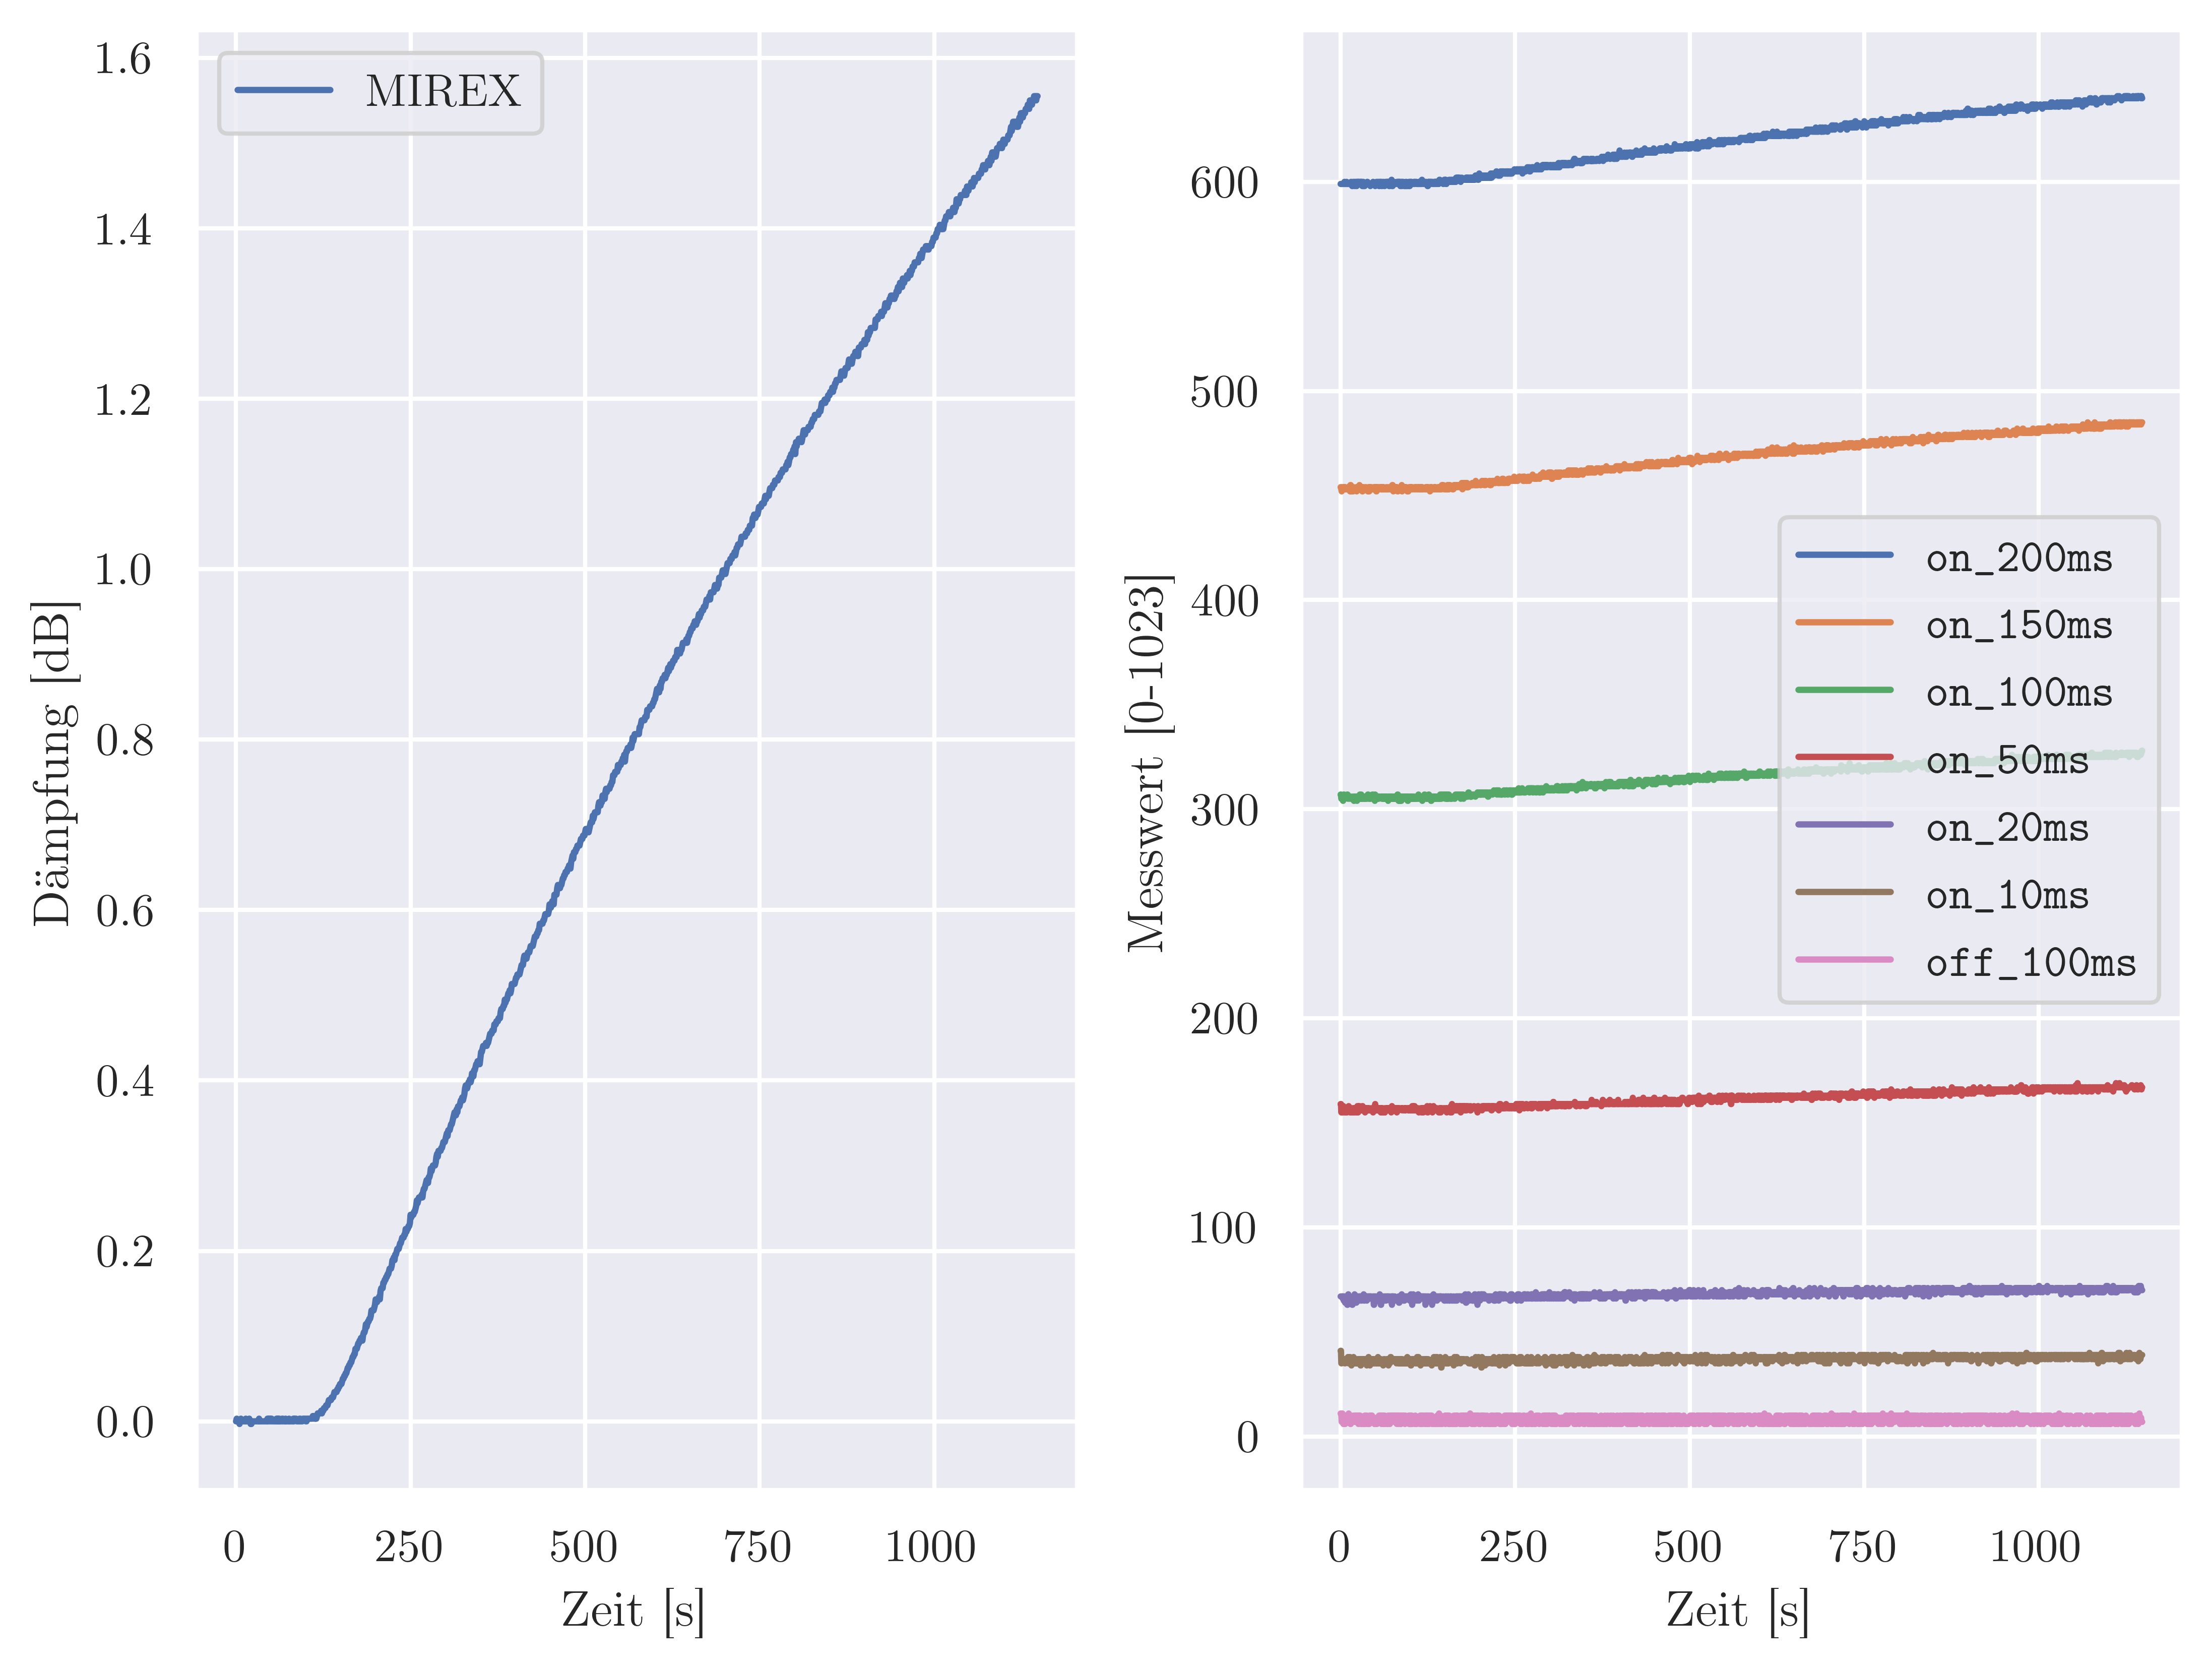

In [5]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

reference.plot(x='sec', y='MIREX', ax=ax[0])
ax[0].set_xlabel("Zeit [s]")
ax[0].set_ylabel("Dämpfung [dB]")
nephelometer.plot(x='sec', y=['on_200ms', 'on_150ms', 'on_100ms', 'on_50ms', 'on_20ms', 'on_10ms', 'off_100ms'], 
                  ax=ax[1])
ax[1].legend([r'\texttt{on\_200ms}', r'\texttt{on\_150ms}', r'\texttt{on\_100ms}', r'\texttt{on\_50ms}', 
              r'\texttt{on\_20ms}', r'\texttt{on\_10ms}', r'\texttt{off\_100ms}'])
ax[1].set_xlabel("Zeit [s]")
ax[1].set_ylabel("Messwert [0-1023]")

#fig.tight_layout()
fig.savefig('messung.png')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


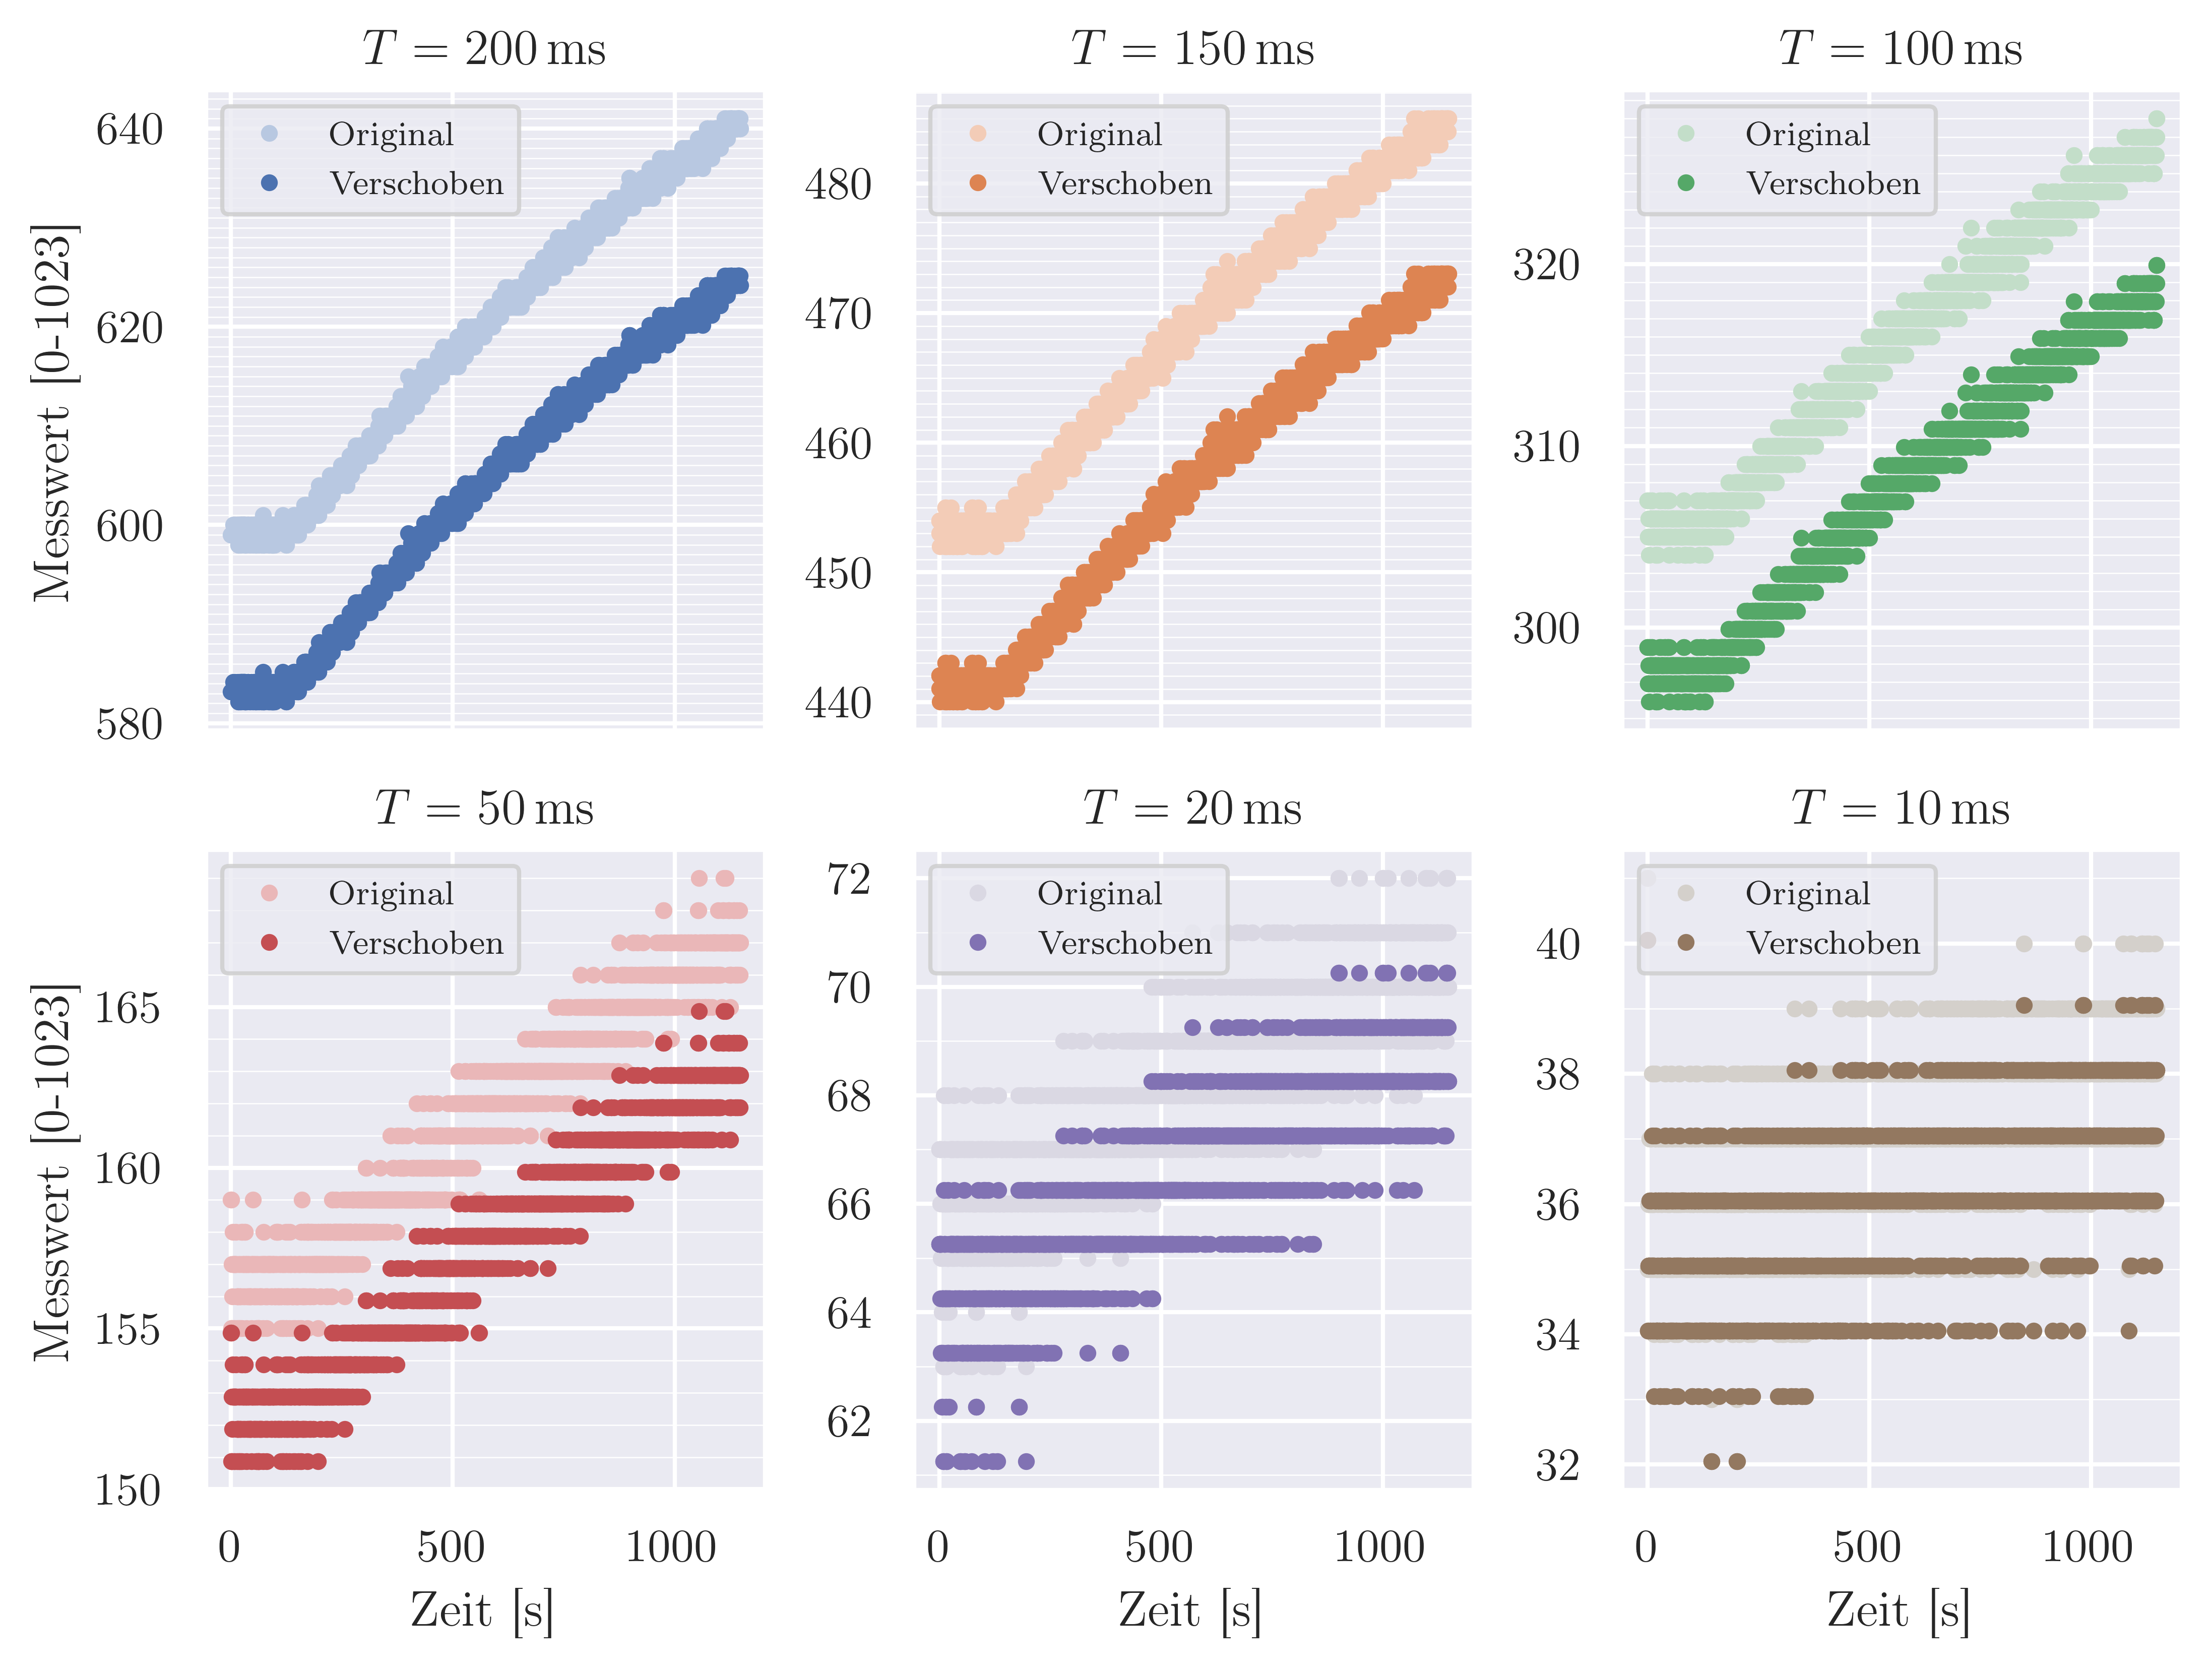

In [6]:
fig, ax = plt.subplots(2, 3, sharex=True, constrained_layout=True)
#gs = ax[-1, 0].get_gridspec()
#for ax_ in ax[-1, :]:
#    ax_.remove()
#axbig = fig.add_subplot(gs[-1, :])

#nephelometer.plot(x='sec', y='i200', style='C0.', ax=ax[0, 0], title=r"$T = \SI{200}{\ms}$", legend=False)
#nephelometer.plot(x='sec', y='i150', style='C1.', ax=ax[0, 1], title=r"$T = \SI{150}{\ms}$", legend=False)
#nephelometer.plot(x='sec', y='i100', style='C2.', ax=ax[0, 2], title=r"$T = \SI{100}{\ms}$", legend=False)
#nephelometer.plot(x='sec', y='i50', style='C3.', ax=ax[1, 0], title=r"$T = \SI{50}{\ms}$", legend=False)
#nephelometer.plot(x='sec', y='i20', style='C4.', ax=ax[1, 1], title=r"$T = \SI{20}{\ms}$", legend=False)
#nephelometer.plot(x='sec', y='i10', style='C5.', ax=ax[1, 2], title=r"$T = \SI{10}{\ms}$", legend=False)

# Lighter colors
c = np.zeros((6, 3))
for i in range(6):
    x = mpl.colors.rgb_to_hsv(mpl.colors.to_rgb(f"C{i}"))
    x[1] **= 3
    x[2] **= 1/3
    c[i, :] = mpl.colors.hsv_to_rgb(x)

nephelometer.plot(x='sec', y='on_200ms', c=c[0, :], style='.', ax=ax[0, 0], title=r"$T = \SI{200}{\ms}$", label="Original", alpha=1)
nephelometer.plot(x='sec', y='on_150ms', c=c[1, :], style='.', ax=ax[0, 1], title=r"$T = \SI{150}{\ms}$", label="Original", alpha=1)
nephelometer.plot(x='sec', y='on_100ms', c=c[2, :], style='.', ax=ax[0, 2], title=r"$T = \SI{100}{\ms}$", label="Original", alpha=1)
nephelometer.plot(x='sec', y='on_50ms', c=c[3, :], style='.', ax=ax[1, 0], title=r"$T = \SI{50}{\ms}$", label="Original", alpha=1)
nephelometer.plot(x='sec', y='on_20ms', c=c[4, :], style='.', ax=ax[1, 1], title=r"$T = \SI{20}{\ms}$", label="Original", alpha=1)
nephelometer.plot(x='sec', y='on_10ms', c=c[5, :], style='.', ax=ax[1, 2], title=r"$T = \SI{10}{\ms}$", label="Original", alpha=1)

nephelometer.plot(x='sec', y='i200', style='C0.', ax=ax[0, 0], title=r"$T = \SI{200}{\ms}$", label="Verschoben")
nephelometer.plot(x='sec', y='i150', style='C1.', ax=ax[0, 1], title=r"$T = \SI{150}{\ms}$", label="Verschoben")
nephelometer.plot(x='sec', y='i100', style='C2.', ax=ax[0, 2], title=r"$T = \SI{100}{\ms}$", label="Verschoben")
nephelometer.plot(x='sec', y='i50', style='C3.', ax=ax[1, 0], title=r"$T = \SI{50}{\ms}$", label="Verschoben")
nephelometer.plot(x='sec', y='i20', style='C4.', ax=ax[1, 1], title=r"$T = \SI{20}{\ms}$", label="Verschoben")
nephelometer.plot(x='sec', y='i10', style='C5.', ax=ax[1, 2], title=r"$T = \SI{10}{\ms}$", label="Verschoben")

ax[0, 0].set_ylabel("Messwert [0-1023]")
ax[1, 0].set_ylabel("Messwert [0-1023]")
for a in ax.flat:
    a.yaxis.grid(True, 'minor', linewidth=.3)
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    a.set_xlabel("Zeit [s]")
    a.legend(fontsize=8, loc='upper left')

#reference['MIREX'].plot(ax=axbig)

#fig.tight_layout()
fig.savefig('verschiebung.png')


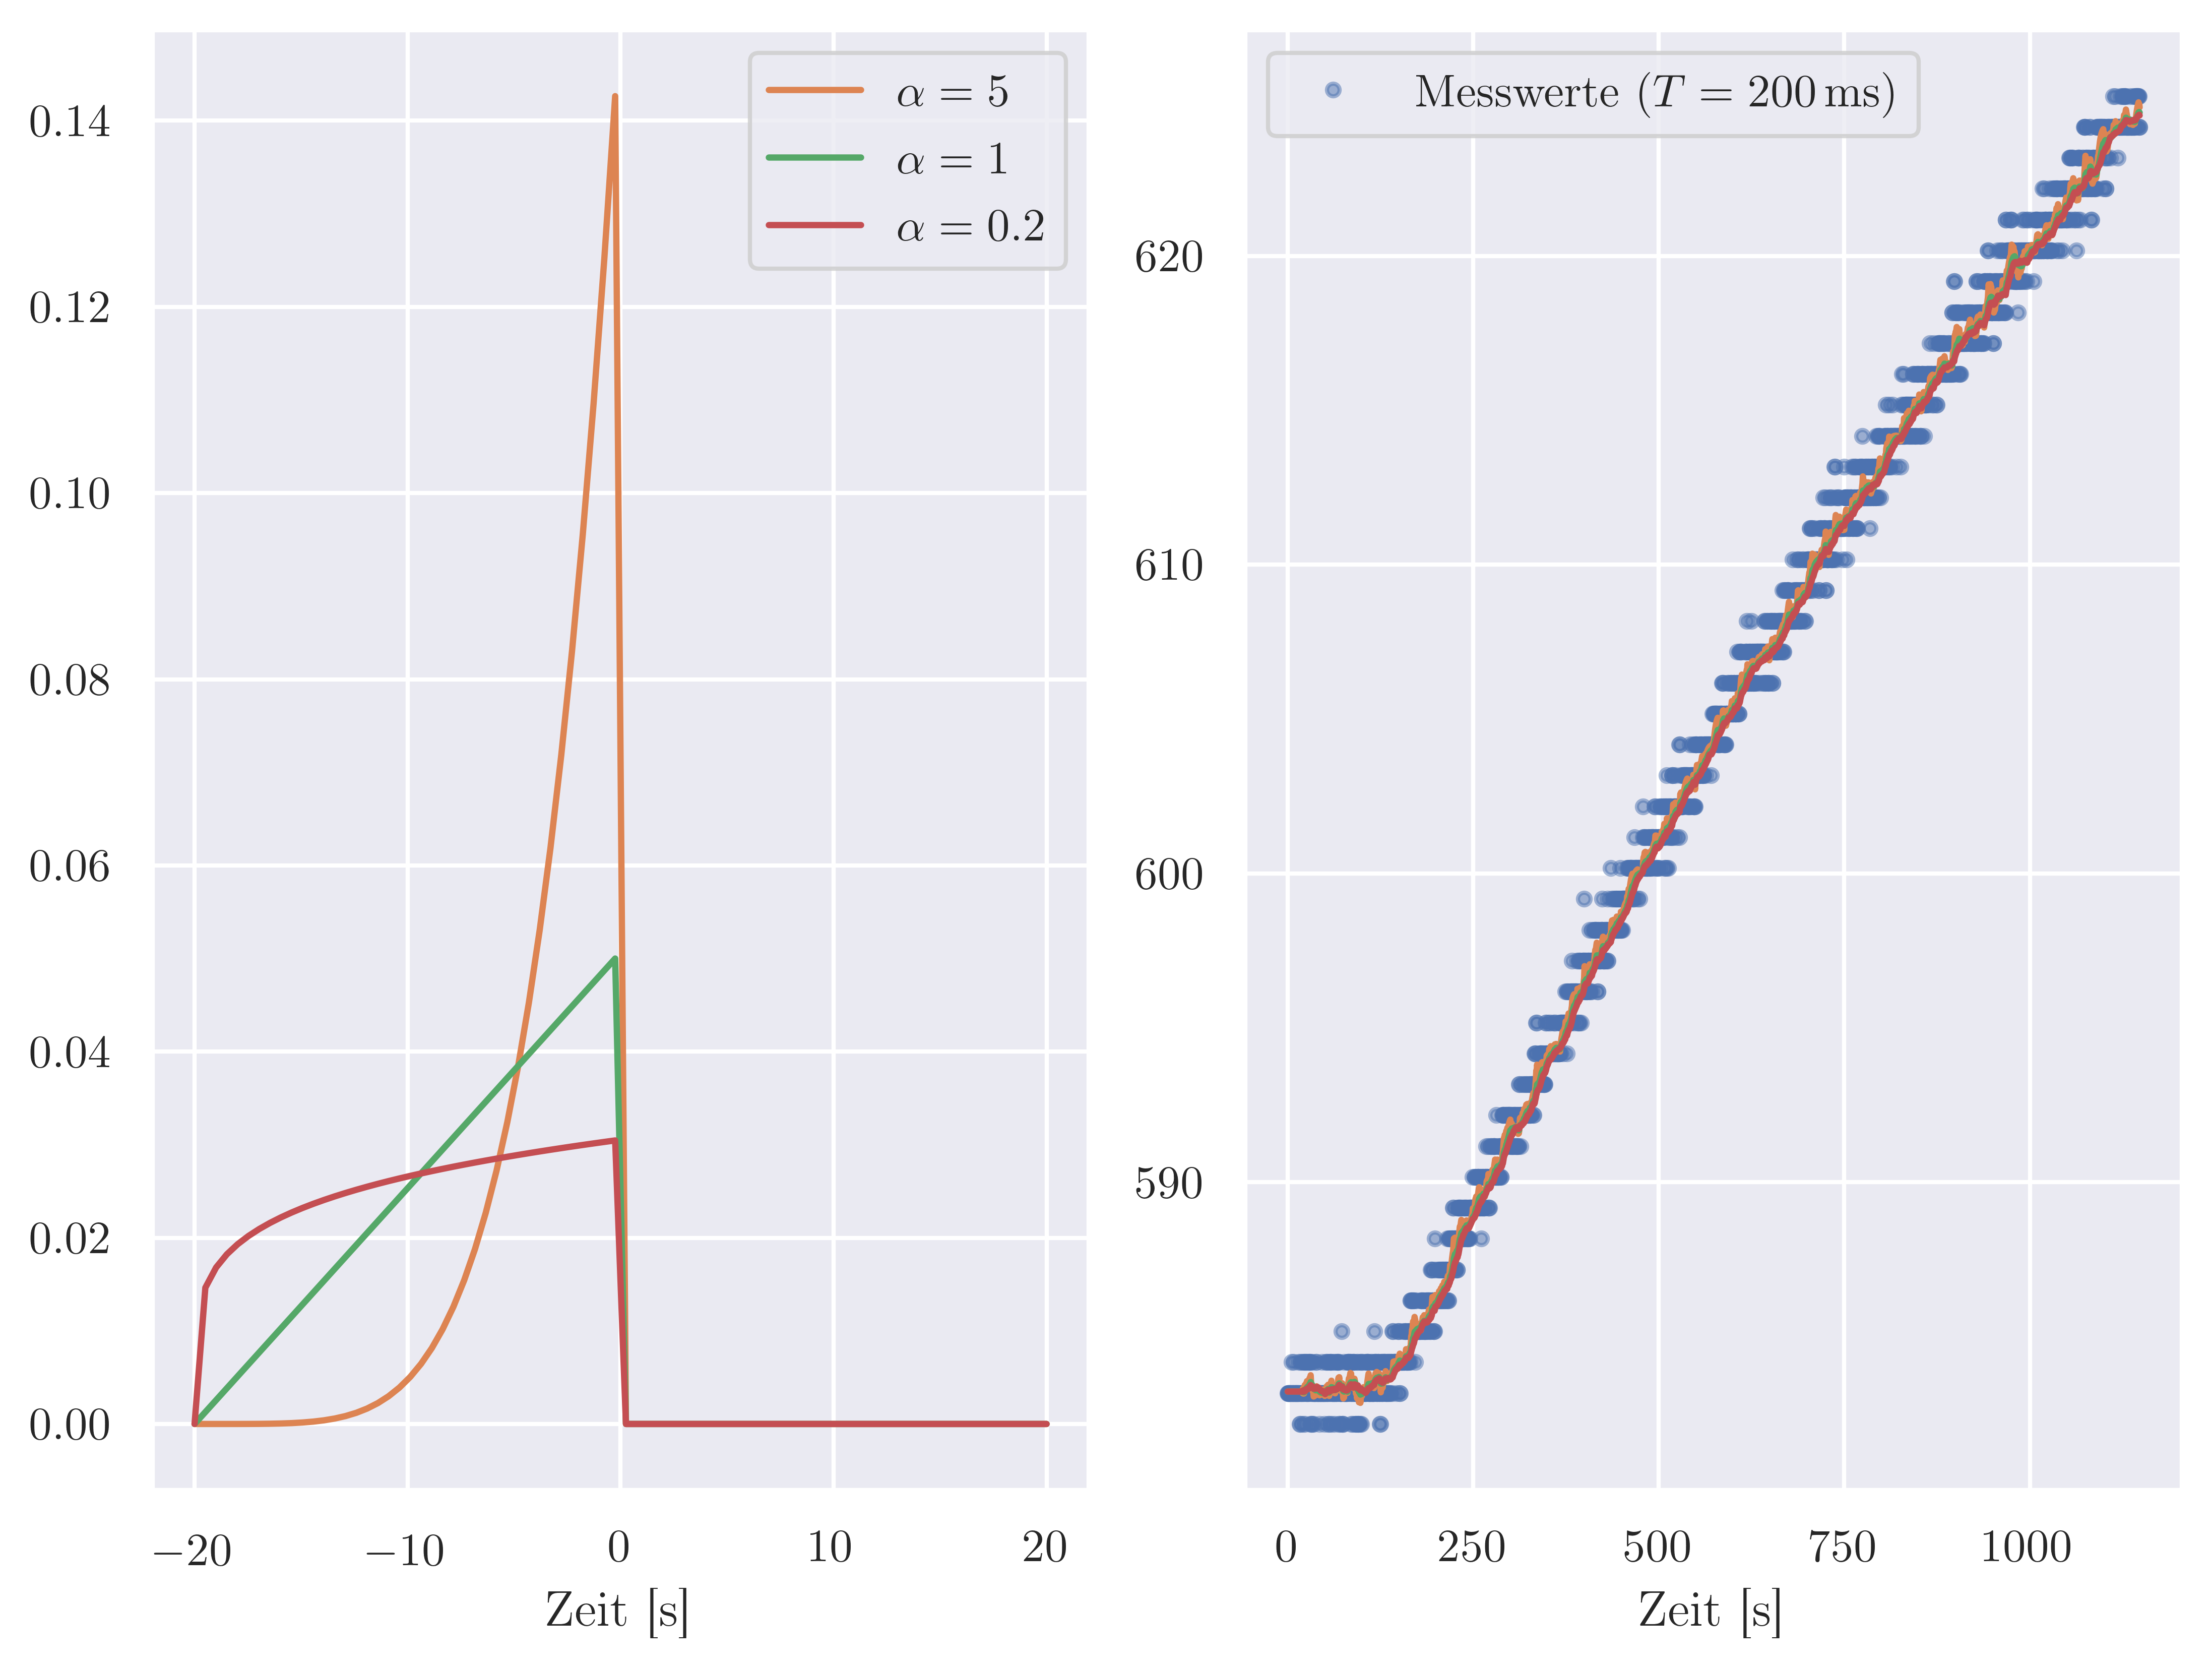

In [7]:
def window(T=40, alpha=1):
    w = np.r_[np.linspace(0, 1, T)**alpha, T*[0]]
    return w / w.sum()    # Normalization

def conv(data, T=40, alpha=1, pad=True):
    win = window(T, alpha)                                                 # Window function
    res = np.r_[T*[np.nan], convolve(data, win[::-1], mode='same')[T:]]    # Convolution
    if pad:
        res = np.r_[T*[data[:T].mean()], res[T:]]                          # Pad beginning
    return res

assert np.allclose([window(alpha=a).sum() for a in [.2, 1, 5]], [1]*3)

fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].plot(np.linspace(-20, 20, 80), window(alpha=5), 'C1', label=r'$\alpha = 5$')       # almost f (dirac)
ax[0].plot(np.linspace(-20, 20, 80), window(alpha=1), 'C2', label=r'$\alpha = 1$')       # linear
ax[0].plot(np.linspace(-20, 20, 80), window(alpha=.2), 'C3', label=r'$\alpha = 0.2$')    # almost mean (boxcar)

#t__ = np.linspace(-20, 0, 40)
#ax[0].plot(np.linspace(-20, 0, 40), (1 + 5) / (2*20**(1+5)) * (t__ + 20)**5, 'C1--', label=r'$\alpha = 5$')       # almost f (dirac)
#ax[0].plot(np.linspace(-20, 0, 40), (1 + 1) / (2*20**(1+1)) * (t__ + 20)**1, 'C2--', label=r'$\alpha = 5$')       # almost f (dirac)
#ax[0].plot(np.linspace(-20, 0, 40), (1 + .2) / (2*20**(1+.2)) * (t__ + 20)**.2, 'C3--', label=r'$\alpha = 5$')       # almost f (dirac)
#print(np.trapz((1 + 5) / 20**(1+5) * (t__ + 20)**5, x=t__))
#print(np.trapz(window(alpha=5), x=np.linspace(-20, 20, 80)))
#print(np.trapz((1 + 5) / 20**(1+5) * (t__ + 20)**5))
#print(np.trapz(window(alpha=5)))

ax[0].set_xlabel(r"Zeit [s]")
#ax[0].set_title(r"Normalisierte Fensterfunktionen der Form $x^\alpha$", fontdict={'fontsize': 10})
ax[0].legend()

ax[1].plot(nephelometer.sec, nephelometer.i200.values, '.', alpha=.5, label='Messwerte ($T = \SI{200}{\ms}$)')
ax[1].plot(nephelometer.sec, conv(nephelometer.i200.values, alpha=5))
ax[1].plot(nephelometer.sec, conv(nephelometer.i200.values, alpha=1))
ax[1].plot(nephelometer.sec, conv(nephelometer.i200.values, alpha=.2))
ax[1].set_xlabel(r"Zeit [s]")
#ax[1].set_title("Geglättete Messwerte", fontdict={'fontsize': 10})
ax[1].legend()

#fig.tight_layout()
fig.savefig('glatt.png')


In [8]:
# Find parameters using the 200ms curve to get the cleanest fit.
neph = conv(nephelometer.i200.values)
ref = reference['MIREX'].values

# Optimization to find actual parameters
t = np.arange(len(neph))
f_ref = interp1d(t, ref, bounds_error=False)
f_neph = interp1d(t, neph, bounds_error=False)

f_model = lambda t, a, b, c: c*f_neph(t - a) + b

def error(x):
    E = (f_ref(t) - f_model(t, x[0], x[1], x[2])) ** 2    # Least squares error
    E[:200] *= 2                                          # Especially penalize bias at 0
    return E[~np.isnan(E)].sum()

# Find optimal parameters using `error` as the objective function
x = None
for a in range(-50, 50):
    x_ = *minimize(error, np.r_[a, 0, 1], bounds=((-100, 100), (None, None), (None, None))).x,
    if x is None or error(x_) < error(x):
        x = x_

a, b, c = *x,    # Optimal parameters
print(a, b, c)

-36.5046091840224 -21.70479394467475 0.03720921123360028


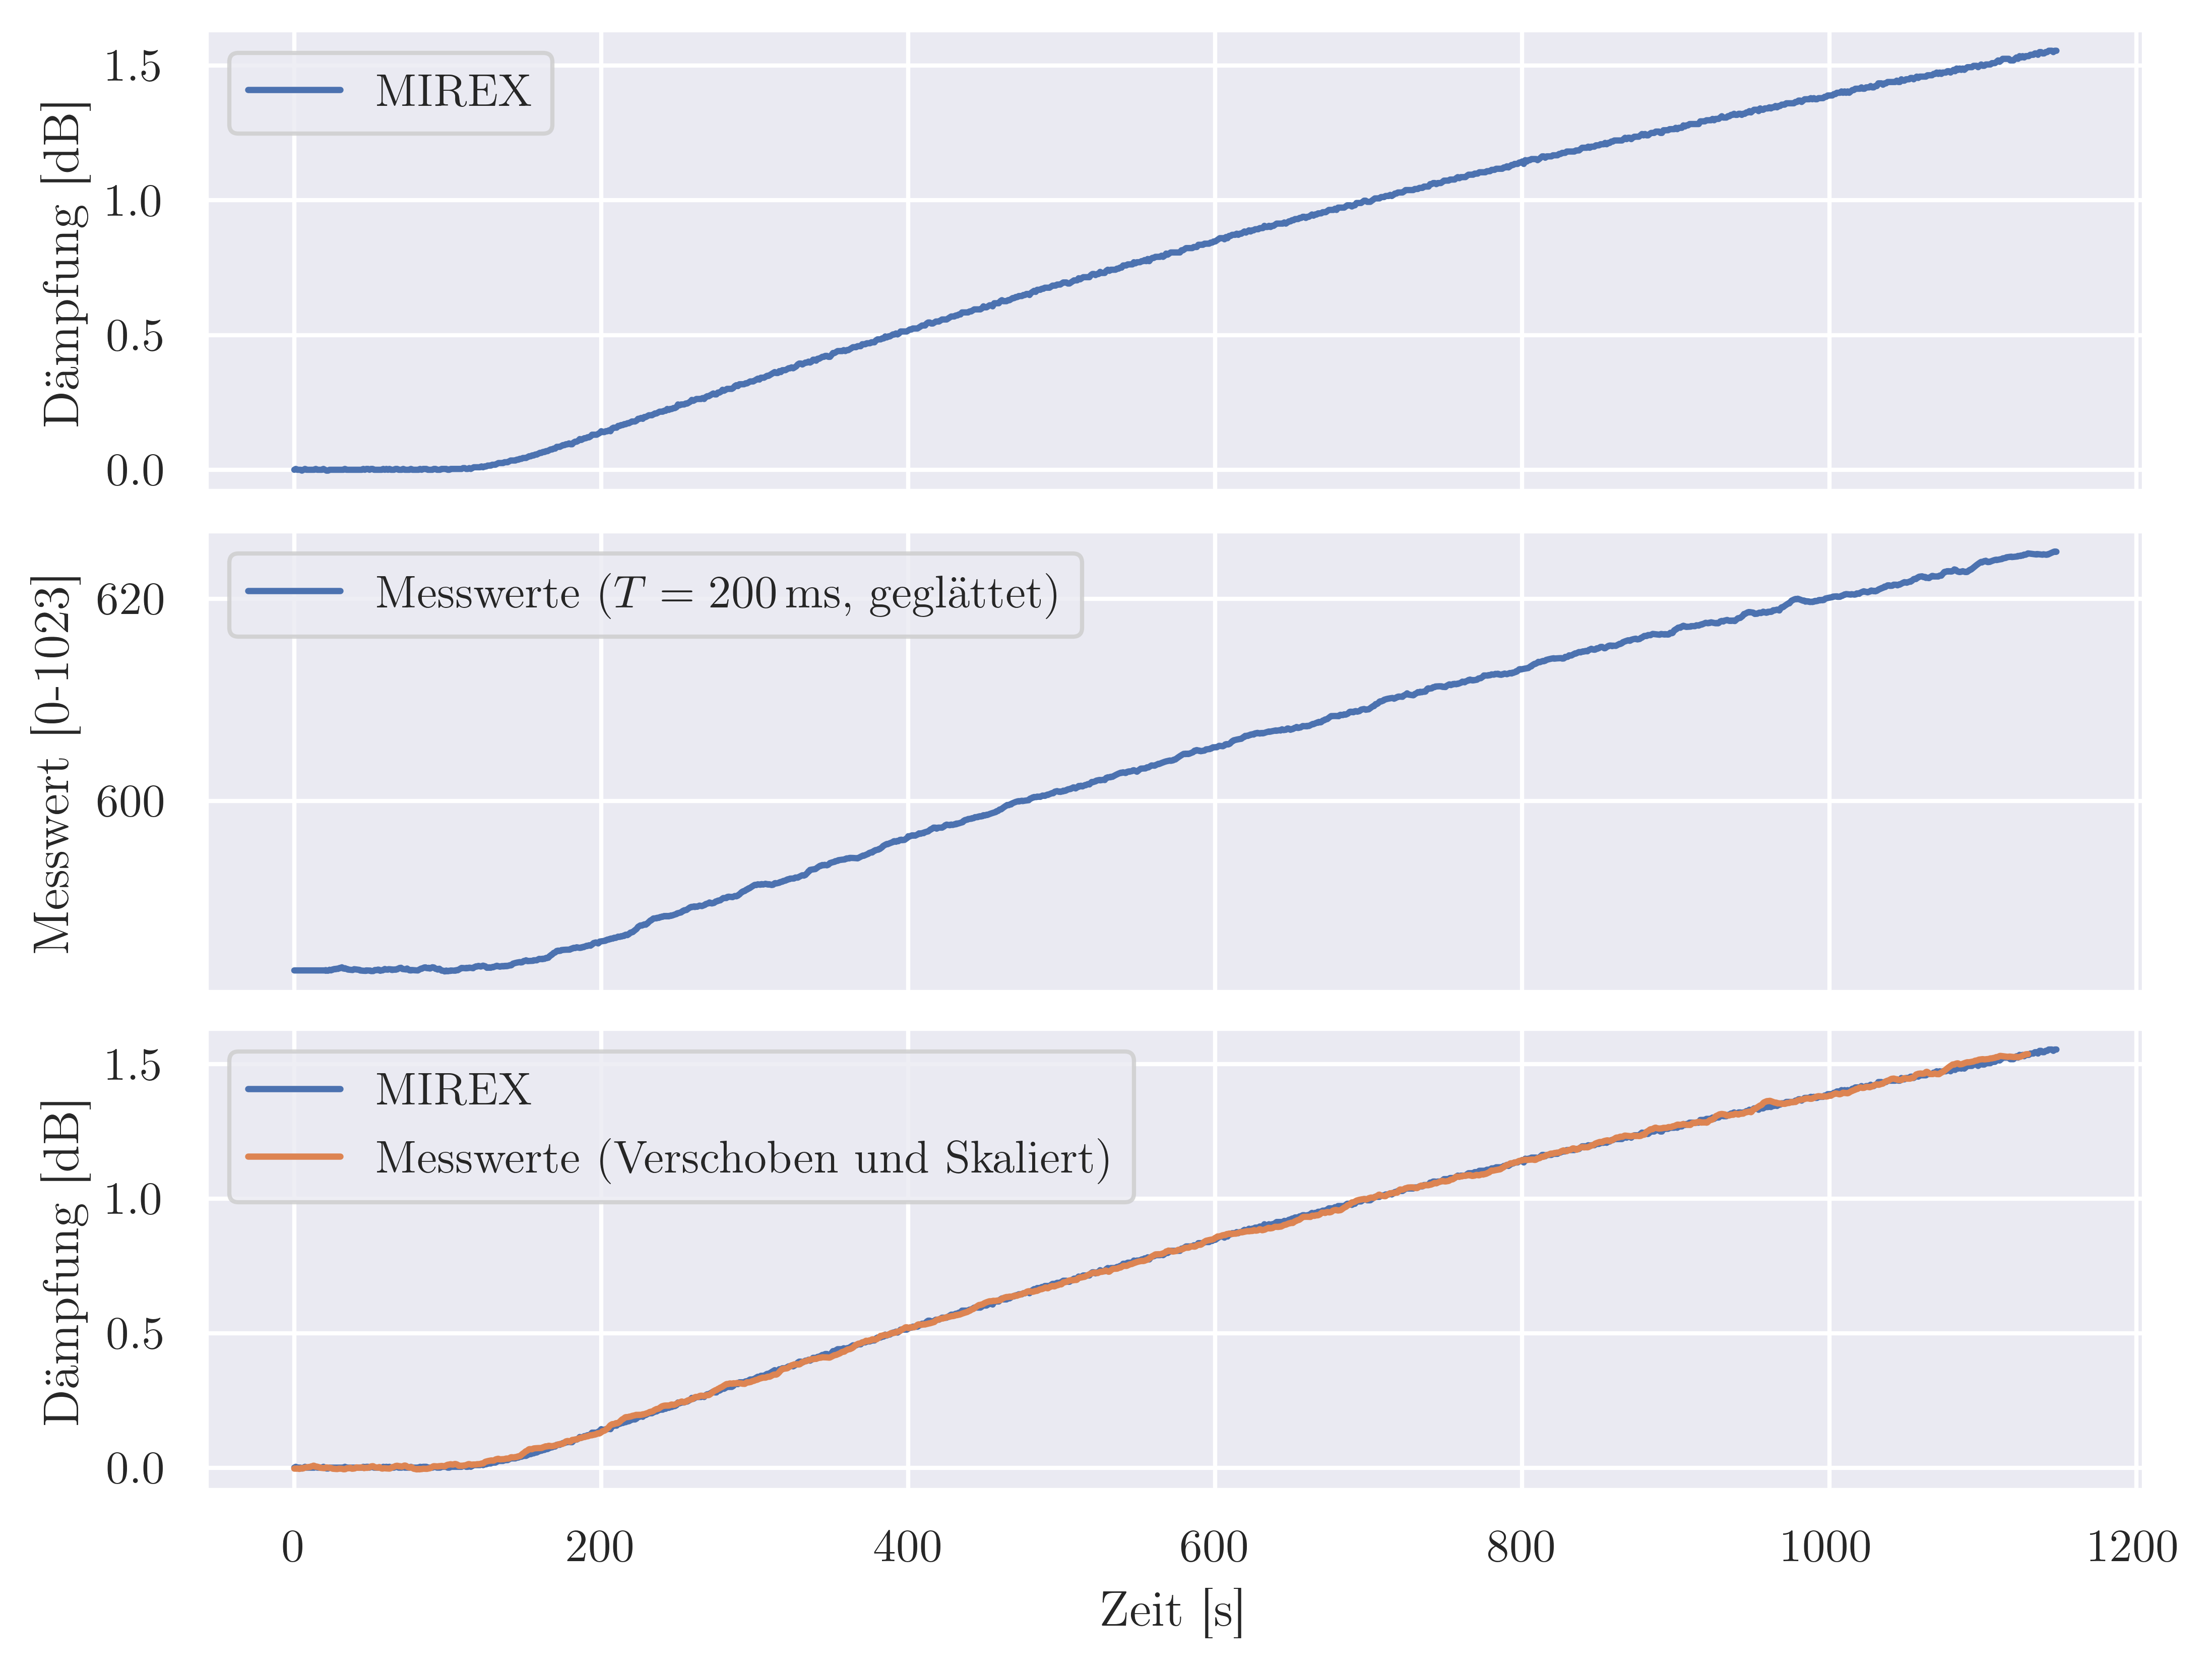

In [9]:
fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True)
ax[0].plot(t/2, ref, label='MIREX')
ax[0].legend()
ax[0].set_ylabel("Dämpfung [dB]")
ax[1].plot(t/2, neph, label='Messwerte ($T = \SI{200}{\ms}$, geglättet)')
ax[1].legend()
ax[1].set_ylabel("Messwert [0-1023]")
ax[2].plot(t/2, f_ref(t), label='MIREX')
ax[2].plot(t/2, f_model(t, a, b, c), label='Messwerte (Verschoben und Skaliert)')
ax[2].legend()
ax[2].set_ylabel("Dämpfung [dB]")
ax[2].set_xlabel("Zeit [s]")
#fig.tight_layout()
fig.savefig('optim.png')

In [10]:
## Parameter 100ms
#k  = c*scale(nephelometer.on_100ms.values, nephelometer.on_200ms.values)
#b  = b
#t0 = a

#print(f"Parameters for 100ms integration:\nScale factor: k = {k}\nOffset: b = {b}\nTime delay: t0 = {t0}"
#      "\nf(t) [dB] = k*m(t - t_0) + b")

#Parameters for 100ms integration:
#Scale factor: k = 74.75869139887239
#Offset: b = -21.705462089794672
#Time delay: t_0 = -36.50545103193768
#f(t) [dB] = k*m(t - t_0) + b

In [11]:
# Parameter 100ms
k  = c*scale(nephelometer.i100.values, nephelometer.i200.values)
b  = b
t0 = a

print(f"Parameters for 100ms integration:\nScale factor: k = {k}\nOffset: b = {b}\nTime delay: t0 = {t0}"
      "\nf(t) [dB] = k*m(t - t_0) + b")

Parameters for 100ms integration:
Scale factor: k = 0.07300424260104722
Offset: b = -21.70479394467475
Time delay: t0 = -36.5046091840224
f(t) [dB] = k*m(t - t_0) + b


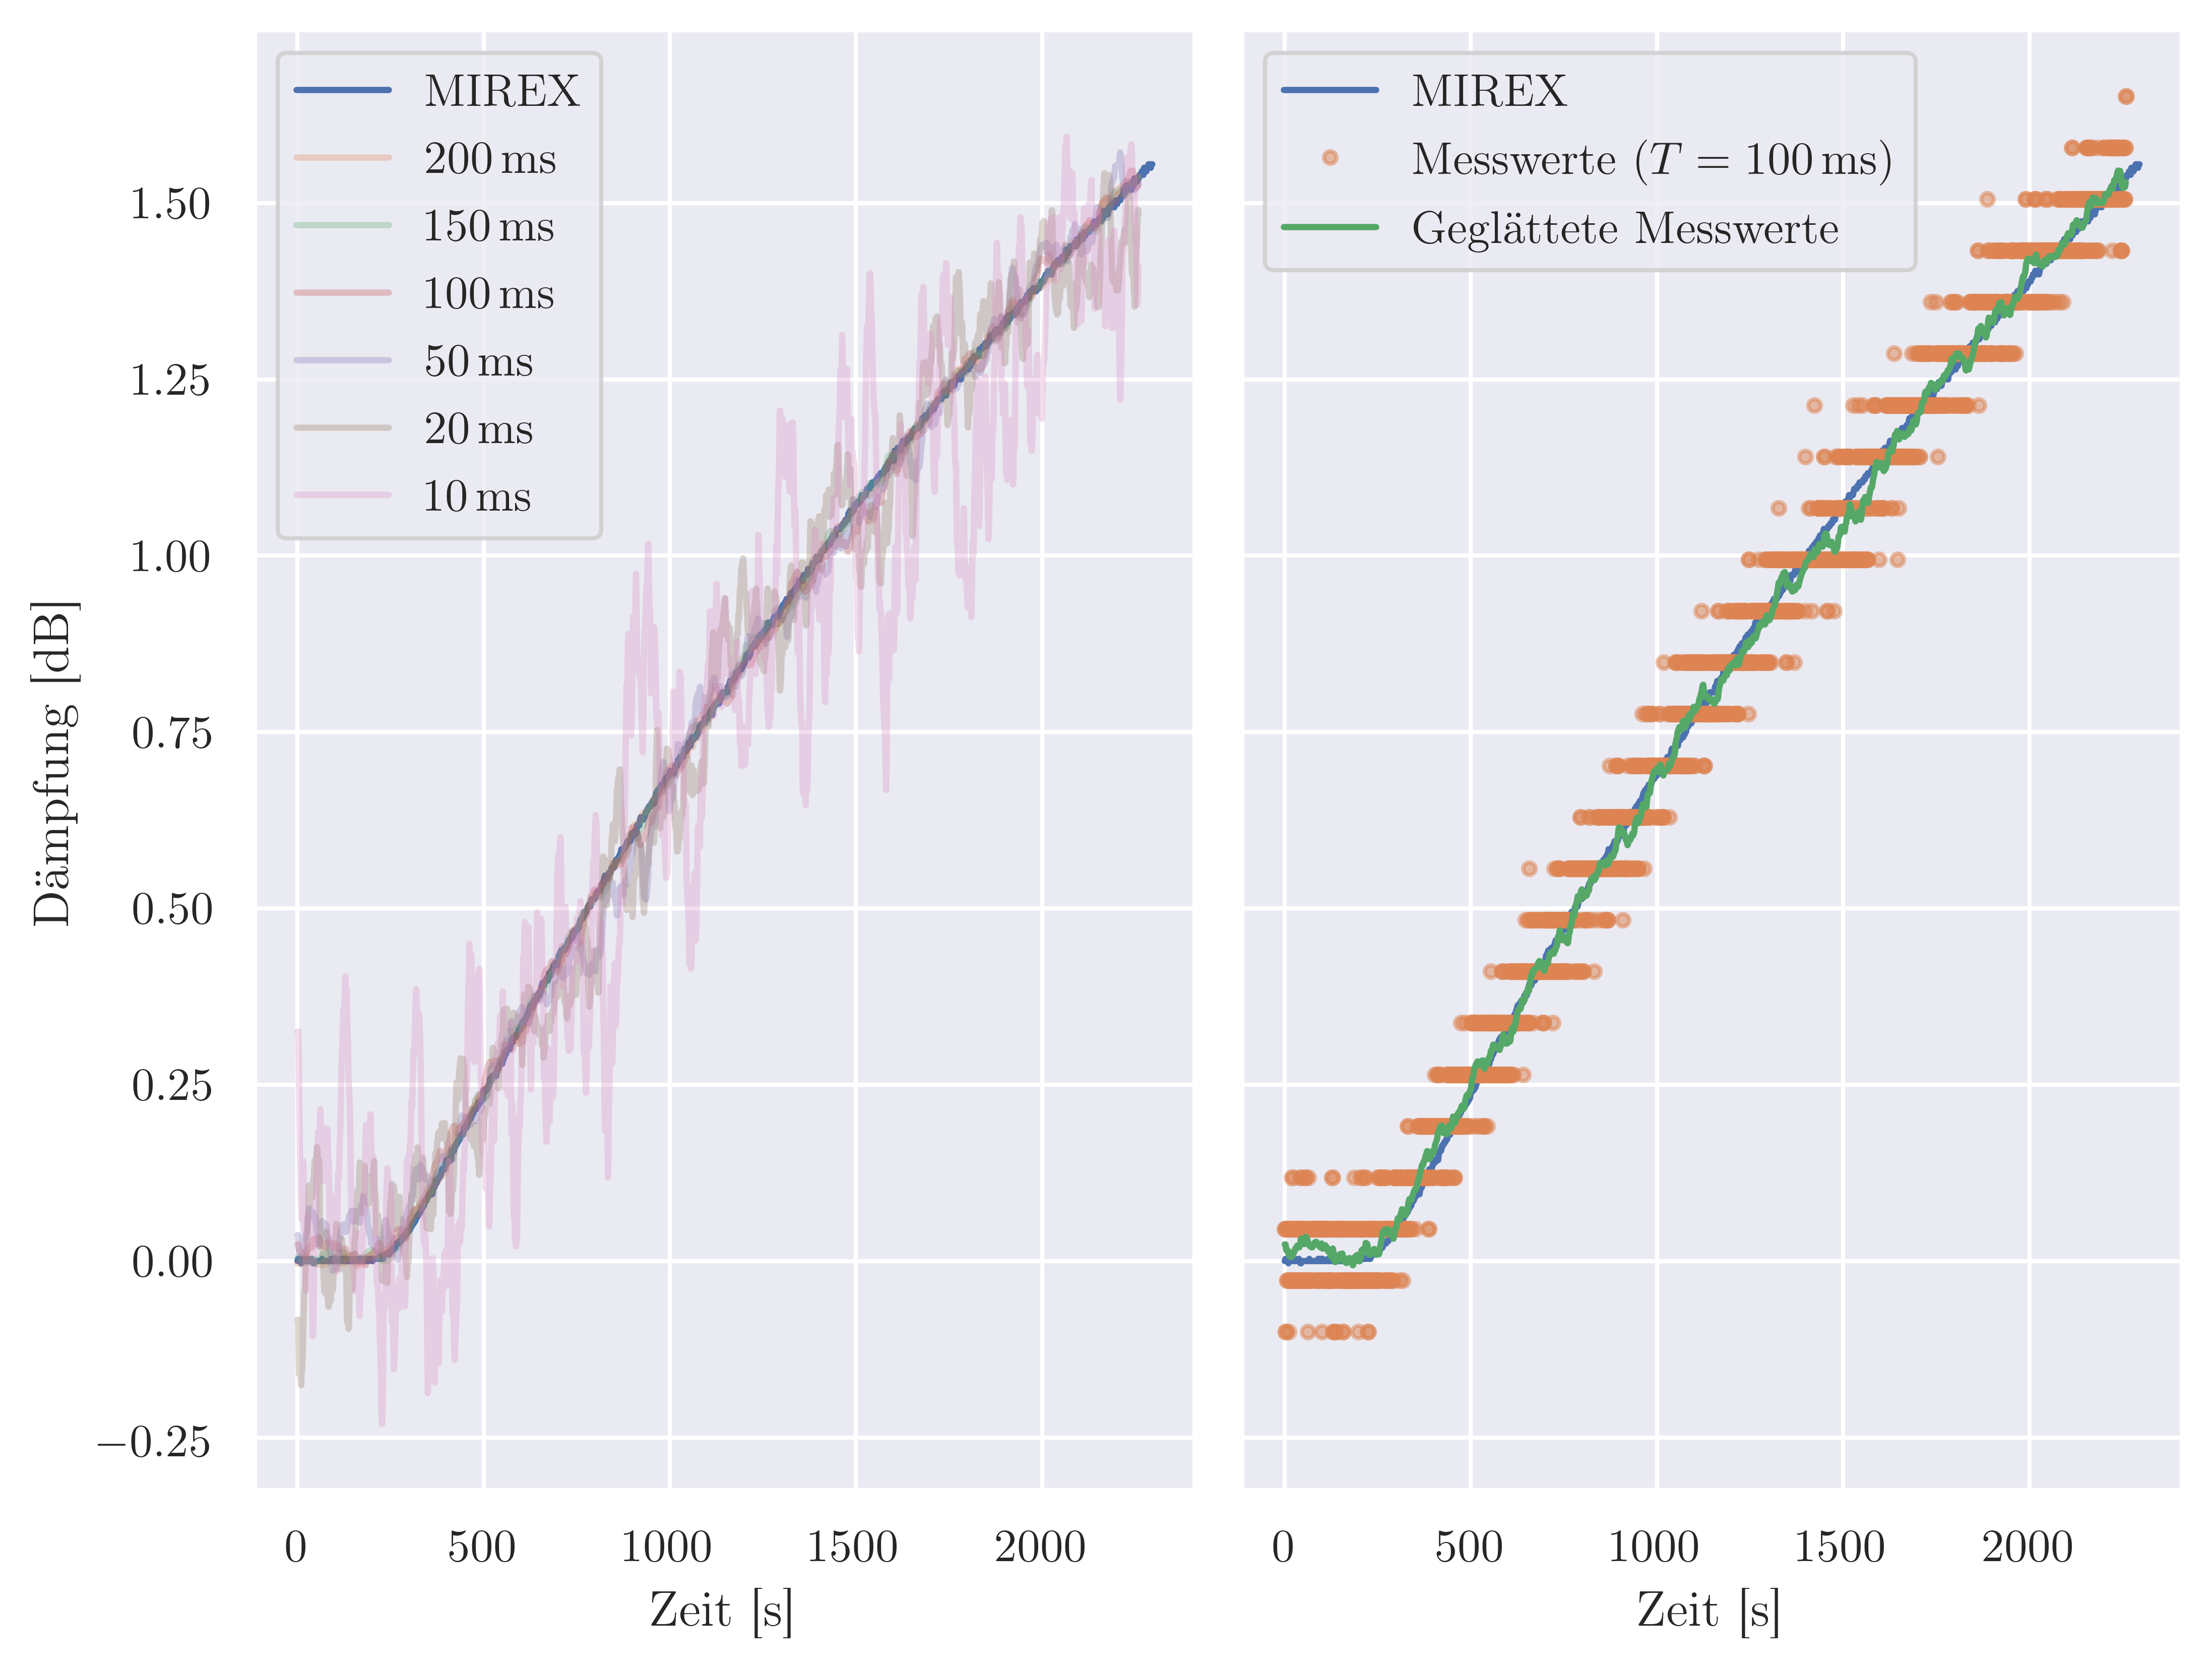

In [12]:
# Testing integrator linearity
def model(data):
    f = interp1d(t, conv(scale(data, nephelometer.i200.values)*data), bounds_error=False)
    return lambda t, a, b, c: c*f(t - a) + b

fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)

ax[0].plot(t, f_ref(t), label='MIREX')
ax[0].plot(t, model(nephelometer.i200.values)(t, a, b, c), alpha=.3, label=r'$\SI{200}{ms}$')
ax[0].plot(t, model(nephelometer.i150.values)(t, a, b, c), alpha=.3, label=r'$\SI{150}{ms}$')
ax[0].plot(t, model(nephelometer.i100.values)(t, a, b, c), alpha=.3, label=r'$\SI{100}{ms}$')
ax[0].plot(t, model(nephelometer.i50.values)(t, a, b, c), alpha=.3, label=r'$\SI{50}{ms}$')
ax[0].plot(t, model(nephelometer.i20.values)(t, a, b, c), alpha=.3, label=r'$\SI{20}{ms}$')
ax[0].plot(t, model(nephelometer.i10.values)(t, a, b, c), alpha=.3, label=r'$\SI{10}{ms}$')
ax[0].legend()

ax[1].plot(t, f_ref(t), label='MIREX')
ax[1].plot(k*nephelometer.i100.values[int(-t0):] + b, '.', alpha=.5, label=r'Messwerte ($T = \SI{100}{\ms}$)')    # Result without smoothing
ax[1].plot(k*interp1d(t, conv(nephelometer.i100.values), bounds_error=False)(t - t0) + b, label='Geglättete Messwerte')    # Result with smoothing
ax[1].legend()


ax[0].set_ylabel("Dämpfung [dB]")
ax[0].set_xlabel("Zeit [s]")
ax[1].set_xlabel("Zeit [s]")

#fig.tight_layout()
fig.savefig('final.png')


In [13]:
sizes = [200, 150, 100, 50, 20, 10]
scales = np.full((6, 6), np.nan)
scales2 = np.full((6, 6), np.nan)
for i, a_ in enumerate(sizes):
    for j, b_ in enumerate(sizes[i:],  i):
        scales[i, j] = scale(nephelometer[f"i{a_}"], nephelometer[f"i{b_}"])
        scales2[i, j] = scales[i, j] / (sizes[j] / sizes[i])

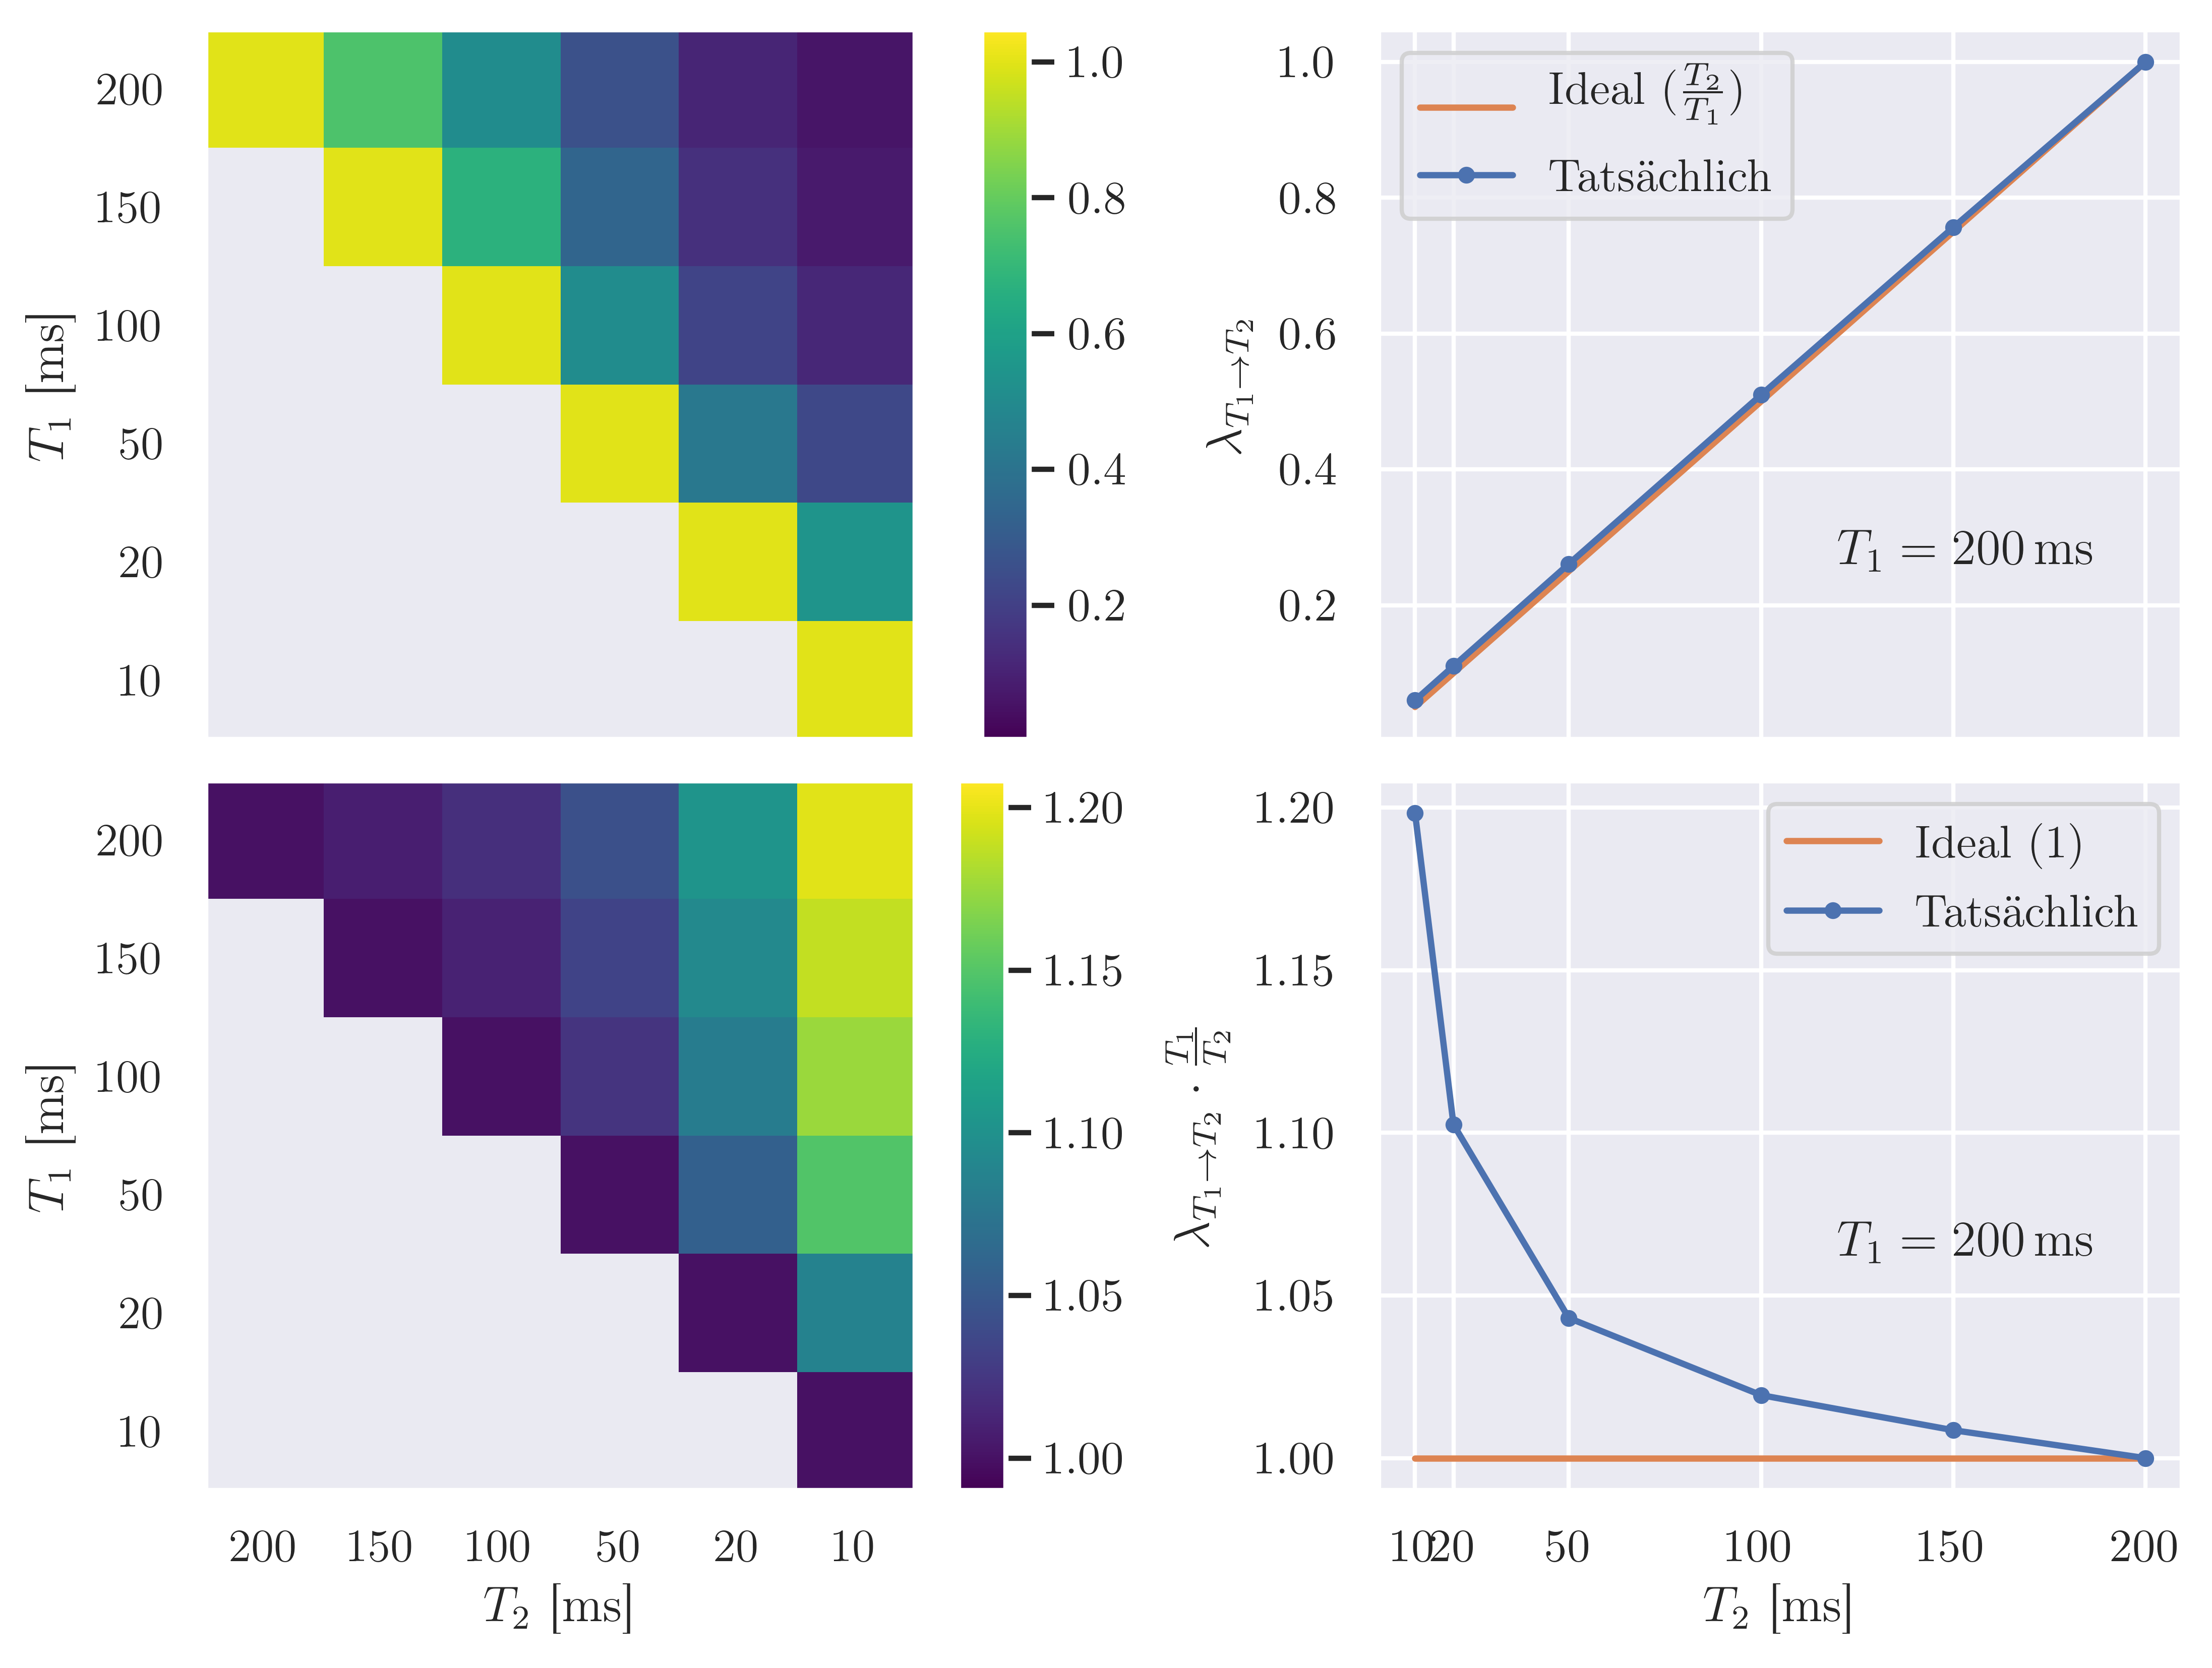

In [14]:
fig, ax = plt.subplots(2, 2, sharex='col', constrained_layout=True)

ax[0, 1].plot(sizes, np.r_[sizes] / 200, 'C1-', label=r"Ideal ($\frac{T_2}{T_1}$)")
ax[0, 1].plot(sizes, scales[0, :], 'C0.-', label="Tatsächlich")
ax[0, 1].text(120, 0.25, r"$T_1 = \SI{200}{\ms}$")
ax[0, 1].legend()
ax[0, 1].set_ylabel(r"$\lambda_{T_1\rightarrow T_2}$")
ax[1, 1].plot(sizes, len(sizes)*[1], 'C1-', label="Ideal (1)")
ax[1, 1].plot(sizes, scales2[0, :], 'C0.-', label="Tatsächlich")
ax[1, 1].text(120, 1.06, r"$T_1 = \SI{200}{\ms}$")
ax[1, 1].legend()
ax[1, 1].set_ylabel(r"$\lambda_{T_1\rightarrow T_2}\cdot\frac{T_1}{T_2}$")
ax[1, 1].set_xticks(sizes)
ax[1, 1].set_xlabel(r"$T_2$ [ms]")

im = ax[0, 0].imshow(scales, cmap='viridis', vmin=ax[0, 1].get_ylim()[0], vmax=ax[0, 1].get_ylim()[1])
cbar = fig.colorbar(im, ax=ax[0, 0])
#cbar.ax.set_ylabel(r"$\lambda_{T_1\rightarrow T_2}$")

ax[0, 0].grid(False)
ax[0, 0].set_xticks(np.arange(0, 6))
ax[0, 0].yaxis.set_major_formatter(mpl.ticker.IndexFormatter(sizes))
ax[0, 0].set_ylabel(r"$T_1$ [ms]")

im = ax[1, 0].imshow(scales2, cmap='viridis', vmin=ax[1, 1].get_ylim()[0], vmax=ax[1, 1].get_ylim()[1])
cbar = fig.colorbar(im, ax=ax[1, 0])
#cbar.ax.set_ylabel(r"$\lambda_{T_1\rightarrow T_2}\cdot\frac{T_1}{T_2}$")

ax[1, 0].grid(False)
ax[1, 0].set_xticks(np.arange(0, 6))
ax[1, 0].yaxis.set_major_formatter(mpl.ticker.IndexFormatter(sizes))
ax[1, 0].xaxis.set_major_formatter(mpl.ticker.IndexFormatter(sizes))
ax[1, 0].set_xlabel(r"$T_2$ [ms]")
ax[1, 0].set_ylabel(r"$T_1$ [ms]")

#fig.tight_layout()
fig.savefig('linear.png')

In [15]:
# Export 100ms data for error checking in matlab
export = nephelometer[['off_100ms', 'on_100ms']]
export.columns = ['off', 'on']
export.to_csv('reference_100ms.csv')